# Modeling Basal Expression with ICA

## Import Packages

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../bitome-kb')
from bitome.core import Bitome

## Load Data

In [2]:
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')

In [3]:
DATA_PATH = Path('data/precise2')

In [4]:
S = pd.read_csv(Path(DATA_PATH, 'S.csv'), index_col=0)
S_binarized = pd.read_csv(Path(DATA_PATH, 'S_binarized.csv'), index_col=0)
A = pd.read_csv(Path(DATA_PATH, 'A.csv'), index_col=0)
metadata = pd.read_csv(Path(DATA_PATH, 'metadata_qc.csv'), index_col=0)
component_info = pd.read_csv(Path(DATA_PATH, 'component_info.csv'), index_col=0)
log_tpm = pd.read_csv(Path(DATA_PATH, 'log_tpm_qc.csv'), index_col=0)
gene_info = pd.read_csv(Path(DATA_PATH, 'gene_info.csv'), index_col=0)
gene_info.loc[:, 'length'] = gene_info['end'] - gene_info['start']

S.columns = component_info['name']
A.index = component_info['name']

In [12]:
wt_index = metadata[
    (metadata['Strain Description'] == 'Escherichia coli K-12 MG1655') &
    (metadata['Base Media'] == 'M9') & 
    (metadata['pH'] == 7.0) & 
    (metadata['Temperature (C)'] == 37) &
    (metadata['project_id'] != 'abx_media')
].index

log_tpm_wt = log_tpm[wt_index]
A_wt = A[wt_index]

## Compute Basal Expression

- For each iModulon, linearly normalize its activity vector so that the minimum value is zero
- then left-multiply that A matrix (A_star) with the S matrix to get expression_adjustment, or log[TPM] due to regulation
- then subtract that expression adjustment from the original expression data to get basal expression

In [9]:
A_star = A_wt.subtract(A_wt.min(axis=1), axis=0)

In [10]:
X_trn = np.dot(S, A_star)

In [13]:
X_basal = log_tpm_wt - X_trn

## Validation: Compare Variance of Gene Expressions Before/After Basal Computation

We expect that the basal expression will have lower variance

In [15]:
cv_X = log_tpm.std(axis=1)
cv_basal = X_basal.std(axis=1)

/Users/cam/.virtualenvs/strainware/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


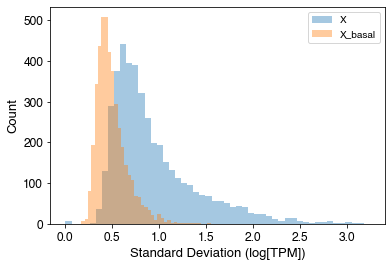

In [16]:
_, ax = plt.subplots()
sns.distplot(cv_X, label='X', kde=False)
sns.distplot(cv_basal, label='X_basal', kde=False)
ax.set_xlabel('Standard Deviation (log[TPM])', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.legend()

## Mean Basal Expression Distribution

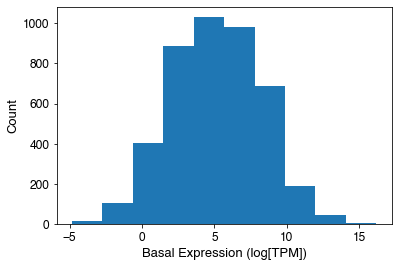

In [17]:
_, ax = plt.subplots()
ax.hist(X_basal.mean(axis=1))
ax.set_xlabel('Basal Expression (log[TPM])', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', labelsize=12)

## Understanding Negative Basal Expression

In [18]:
mean_basal_neg = X_basal.mean(axis=1)[X_basal.mean(axis=1) < -1].sort_values()

/Users/cam/.virtualenvs/strainware/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


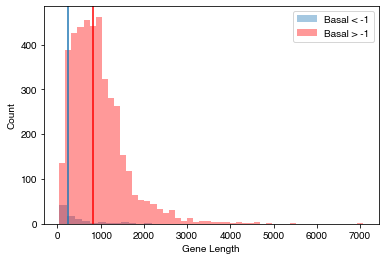

In [19]:
_, ax = plt.subplots()
sns.distplot(gene_info.loc[mean_basal_neg.index]['length'], label='Basal < -1', ax=ax, kde=False)
sns.distplot(gene_info.drop(index=mean_basal_neg.index)['length'], label='Basal > -1', ax=ax, kde=False, color='red')
ax.axvline(gene_info.loc[mean_basal_neg.index]['length'].median())
ax.axvline(gene_info.drop(index=mean_basal_neg.index)['length'].median(), color='red')
ax.set_xlabel('Gene Length')
ax.set_ylabel('Count')
ax.legend()

So it looks like on average, the negative basal expression genes are much shorter than the other genes; perhaps noise due to short genes is a contributor to ending up with negative basal expression

Let's take a look at the most negative basal expressions:

In [20]:
mean_basal_neg.iloc[:10, ]

Geneid
b4601   -4.852013
b4632   -4.761806
b4748   -4.315398
b4749   -4.282938
b4666   -4.186377
b1348   -3.913291
b4671   -3.729024
b4638   -3.508610
b4722   -3.380230
b0734   -3.102383
dtype: float64

b0593 is entC: let's see which iModulons contribute the most to the expression adjustments being so large, and thus the basal expressions being so negative:

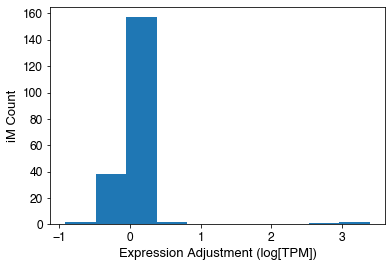

In [21]:
entc_glucose = S.loc['b0593', :].values * A_star.iloc[:, 0].values
_, ax = plt.subplots()
ax.hist(entc_glucose)
ax.set_xlabel('Expression Adjustment (log[TPM])', fontsize=13)
ax.set_ylabel('iM Count', fontsize=13)
ax.tick_params(axis='both', labelsize=12)

In [22]:
S.columns[np.where(entc_glucose > 2)[0]]

Index(['Fur-1', 'Fur-2', 'entC-KO'], dtype='object', name='name')

Interestingly, the big contributors to high entC expression adjustments are iModulons that entC is in, especially the KO...is the KO flipped?

So at this point, let's try just using the regulatory iModulons and repeating everything

## Repeating the Above, excluding KO and SG iModulons

In [23]:
ims_to_keep = component_info[
    ~component_info['name'].str.contains('KO|SG|BW|deletion|INS|repair|duplication|prophage|uncharacterized')
]['name']

S_reg = S[ims_to_keep]
A_reg = A_wt.loc[ims_to_keep]

### Compute Basal Expression

In [24]:
A_star_reg = A_reg.subtract(A_reg.min(axis=1), axis=0)

In [26]:
X_trn_reg = pd.DataFrame(np.dot(S_reg, A_star_reg), index=log_tpm_wt.index, columns=log_tpm_wt.columns)

In [27]:
X_basal_reg = log_tpm_wt - X_trn_reg

### Check CV of Basal Expression

/Users/cam/.virtualenvs/strainware/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


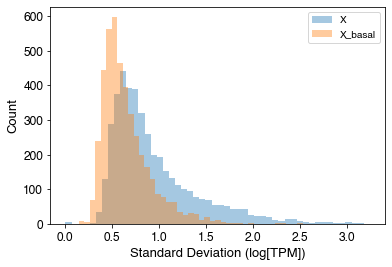

In [28]:
cv_basal_reg = X_basal_reg.std(axis=1)

_, ax = plt.subplots()
sns.distplot(cv_X, label='X', kde=False)
sns.distplot(cv_basal_reg, label='X_basal', kde=False)
ax.set_xlabel('Standard Deviation (log[TPM])', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.legend()

### Check Mean Basal Expressions

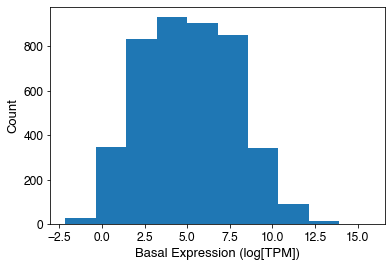

In [29]:
_, ax = plt.subplots()
ax.hist(X_basal_reg.mean(axis=1))
ax.set_xlabel('Basal Expression (log[TPM])', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', labelsize=12)

### Investigate Negative Basal Expressions

/Users/cam/.virtualenvs/strainware/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


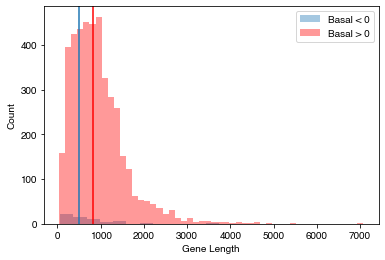

In [30]:
mean_basal_neg_reg = X_basal_reg.mean(axis=1)[X_basal_reg.mean(axis=1) < 0].sort_values()

_, ax = plt.subplots()
sns.distplot(gene_info.loc[mean_basal_neg_reg.index]['length'], label='Basal < 0', ax=ax, kde=False)
sns.distplot(gene_info.drop(index=mean_basal_neg_reg.index)['length'], label='Basal > 0', ax=ax, kde=False, color='red')
ax.axvline(gene_info.loc[mean_basal_neg_reg.index]['length'].median())
ax.axvline(gene_info.drop(index=mean_basal_neg_reg.index)['length'].median(), color='red')
ax.set_xlabel('Gene Length')
ax.set_ylabel('Count')
ax.legend()

Okay, so we'd say we're happy with this result, more things seem to be above 0 but we're still getting a solid reduction in variance across the board. Let's try to do more validation on the non-genomic-alterations basal expression

## Validation: Compare Changed Expression in Clear Activator/Repressor Cases

In [31]:
locus_tag_to_name = dict(zip(gene_info.index, gene_info['gene_name']))

In [32]:
def iM_expression_adjustments(iM, figsize=(8, 5)):

    X_trn_im = pd.DataFrame(columns=['gene', 'adjust'])

    iM_locus_tags = S_binarized[S_binarized[iM] == 1].index

    for tag in iM_locus_tags:
        gene_name = locus_tag_to_name[tag]
        adjusts = (S_reg.loc[tag, iM] * A_star_reg.loc[iM, :].values) * -1
        X_trn_im = X_trn_im.append(pd.DataFrame(data={'gene': gene_name, 'adjust': adjusts}))

    _, ax = plt.subplots(figsize=figsize)
    sns.boxplot(x='gene', y='adjust', data=X_trn_im)
    ax.set_xlabel('')
    ax.set_ylabel(f'{iM} Exp Adjust ([log[TPM])', fontsize=13)
    ax.tick_params(axis='both', labelsize=12)
    ax.axhline(0, linestyle='--', color='gray')

### PrpR (Small iModulon/Regulon, Strictly Activates)

PrpR should activate expression of prpBCDE and repress its own expression

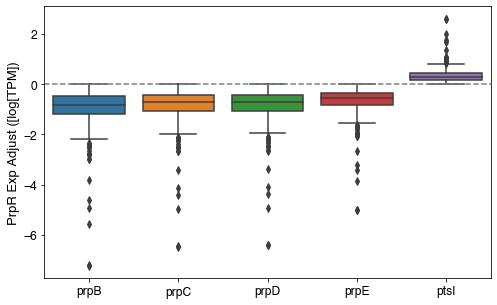

In [33]:
iM_expression_adjustments('PrpR')

So we see what we expect! The PrpR iModulon's contribution to expression adjustment is to lower the expression of prpBCDE and slightly raise its own expression, counteracting the effect of the regulation. 

### MalT (Small iModulon/Regulon, Strictly Activates)

MalT should activate expression of mal genes

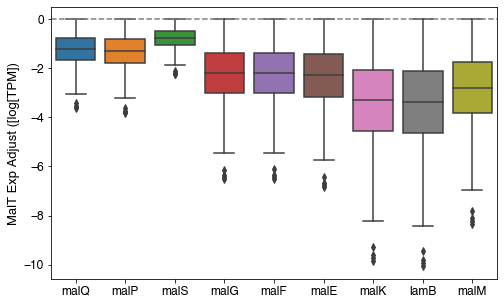

In [34]:
iM_expression_adjustments('MalT')

Also seems to follow the expected pattern; the genes' expressions are down-adjusted to account for MalT activation

### LsrR (Small iModulon/Regulon, Strictly Represses)

We expect this time to see positive adjustments

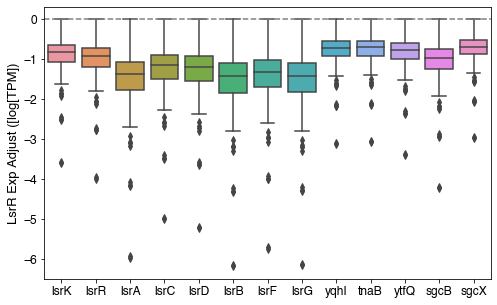

In [35]:
iM_expression_adjustments('LsrR')

So this actually had negative adjustments, maybe the signs are wrong in the S vector here

### CysB (Medium iModulon/Regulon, Dual Activator)

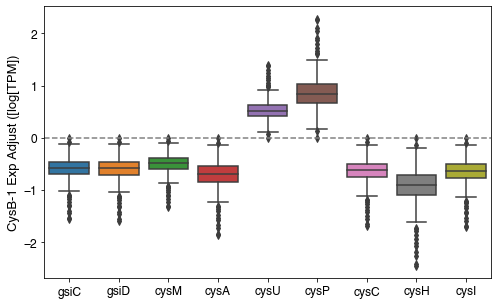

In [36]:
iM_expression_adjustments('CysB-1')

## Using iModulon Directions

In [37]:
im_directions = {
    'translation': 1,
    'MalT': 1,
    'GalR+GalS': -1,
    'RhaS': 1,
    'FlhDC/FliA': 1,
    'CysB-1': 1,
    'PurR-1': -1,
    'FDH-O': 1,
    'GlrR/RpoE': 1,
    'TdcA+TdcR/CadC': 1,
    'DhaR/Mlc': -1,
    'curli': 1,
    'PuuR': -1,
    'dppABCDF': 1,
    'membrane': 1,
    'AppY-1': 1,
    'GcvA': -1,
    'BirA': -1,
    'BluR': -1,
    'PhoB-1': 1,
    'PhoP': 1,
    'YgeV': 1,
    'NagC': -1,
    'Thiamine-1': 1,
    'Fur-1': -1,
    'YgbI': 1,
    'TyrR': -1,
    'N-related': 1,
    'GutM/GutR': 1,
    'RcsAB': 1,
    'NikR': -1,
    'Fnr-2': 1,
    'Nac': 1,
    'NarL': -1,
    'PhoB-2': 1,
    'EvgA': 1,
    'N-Red-Z': 1,
    'NarL+NarP': 1,
    'Cbl+CysB': 1,
    'PrpR': 1,
    'CysB-2': 1,
    'Polymixin': 1,
    'AtoC': 1,
    'SoxS': 1,
    'NarP': 1,
    'NtrC+RpoN': 1,
    'RpoS': 1,
    'NarL+NarP+NsrR': 1,
    'OxyR': 1,
    'GatR+Crp': -1,
    'AraC/AllR/FucR': -1,
    'SoxS-anti': 1,
    'NDH-1': 1,
    'ppGpp': 1,
    'Iron Uptake': 1,
    'FecI': 1,
    'IscR': 1,
    'LexA': -1,
    'YcjW': 1,
    'RyhB/IscR': -1,
    'Lrp': -1,
    'Leucine': 1,
    'flu-yeeRS': 1,
    'RbsR': -1,
    'CsqR': -1,
    'LPS': 1,
    'LsrR': -1,
    'AppY-2': 1,
    'Cra': -1,
    'Glutamine': 1,
    'NrdR': -1,
    'Histidine': 1,
    'Zur': -1,
    'Copper': 1,
    'XylR': 1,
    'GlpR': -1,
    'CdaR': 1,
    'RpoH': 1,
    'YiaJ': -1,
    'FlhDC': 1,
    'KdpE': 1,
    'GadEWX': 1,
    'ArgR': -1,
    'GlcC': 1,
    'IclR': -1,
    'Cytochrome-bo': 1,
    'FliA': 1,
    'NDH-2': 1,
    'Tryptophan': -1,
    'FhlA': 1,
    'ProVWX': 1,
    'GntR': -1,
    'ExuR/FucR': 1,
    'oppABCDF': 1,
    'Mo-Transport': 1,
    'PurR-2': -1,
    'Fnr-1': 1,
    'MetJ': -1,
    'Fimbriae': 1,
    'MarR': -1,
    'ArgP': 1,
    'YieP': 1,
    'Fur-2': -1,
    'CpxR': 1,
    'PaaX': -1,
    'ArcA-1': -1,
    'FadR': -1,
    'BCAA-1': 1,
    'LldR': -1,
    'NanR': -1,
    'BCAA-2': 1,
    'Thiamine-2': 1,
    'BCAA-3': 1,
    'GadW': 1
}

In [38]:
im_dirs = np.array(list(im_directions.values()))

S_reg_dir = S_reg * im_dirs

### Compute Basal Expression

In [39]:
X_trn_reg_dir = pd.DataFrame(np.dot(S_reg_dir, A_star_reg), index=log_tpm_wt.index, columns=log_tpm_wt.columns)

In [40]:
X_basal_reg_dir = log_tpm_wt - X_trn_reg_dir

### Check CV of Basal Expression

/Users/cam/.virtualenvs/strainware/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


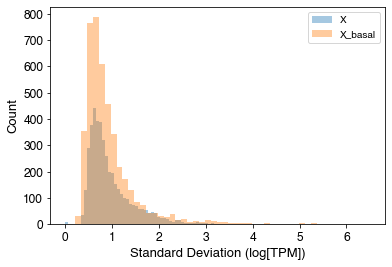

In [41]:
cv_basal_reg_dir = X_basal_reg_dir.std(axis=1)

_, ax = plt.subplots()
sns.distplot(cv_X, label='X', kde=False)
sns.distplot(cv_basal_reg_dir, label='X_basal', kde=False)
ax.set_xlabel('Standard Deviation (log[TPM])', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.legend()

### Check Mean Basal Expressions

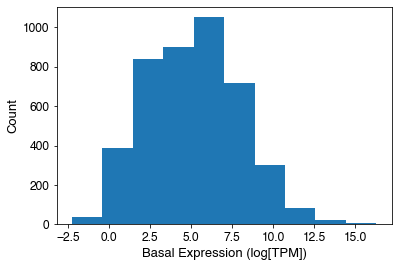

In [42]:
_, ax = plt.subplots()
ax.hist(X_basal_reg_dir.mean(axis=1))
ax.set_xlabel('Basal Expression (log[TPM])', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', labelsize=12)

### Investigate Negative Basal Expressions

/Users/cam/.virtualenvs/strainware/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


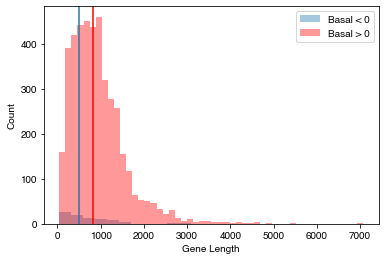

In [43]:
mean_basal_neg_reg_dir = X_basal_reg_dir.mean(axis=1)[X_basal_reg_dir.mean(axis=1) < 0].sort_values()

_, ax = plt.subplots()
sns.distplot(gene_info.loc[mean_basal_neg_reg_dir.index]['length'], label='Basal < 0', ax=ax, kde=False)
sns.distplot(gene_info.drop(index=mean_basal_neg_reg_dir.index)['length'], label='Basal > 0', ax=ax, kde=False, color='red')
ax.axvline(gene_info.loc[mean_basal_neg_reg_dir.index]['length'].median())
ax.axvline(gene_info.drop(index=mean_basal_neg_reg_dir.index)['length'].median(), color='red')
ax.set_xlabel('Gene Length')
ax.set_ylabel('Count')
ax.legend()

Okay, so we'd say we're happy with this result, more things seem to be above 0 but we're still getting a solid reduction in variance across the board. Let's try to do more validation on the non-genomic-alterations basal expression

## Validation: Compare Changed Expression in Clear Activator/Repressor Cases

In [44]:
def iM_expression_adjustments_dir(iM, figsize=(8, 5)):

    X_trn_im = pd.DataFrame(columns=['gene', 'adjust'])

    iM_locus_tags = S_binarized[S_binarized[iM] == 1].index

    for tag in iM_locus_tags:
        gene_name = locus_tag_to_name[tag]
        adjusts = (S_reg_dir.loc[tag, iM] * A_star_reg.loc[iM, :].values) * -1
        X_trn_im = X_trn_im.append(pd.DataFrame(data={'gene': gene_name, 'adjust': adjusts}))

    _, ax = plt.subplots(figsize=figsize)
    sns.boxplot(x='gene', y='adjust', data=X_trn_im)
    ax.set_xlabel('')
    ax.set_ylabel(f'{iM} Exp Adjust ([log[TPM])', fontsize=13)
    ax.tick_params(axis='both', labelsize=12)
    ax.axhline(0, linestyle='--', color='gray')

### PrpR (Small iModulon/Regulon, Strictly Activates)

PrpR should activate expression of prpBCDE and repress its own expression

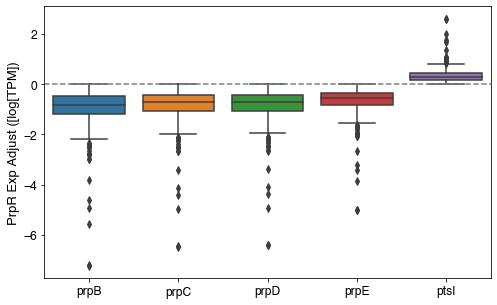

In [45]:
iM_expression_adjustments_dir('PrpR')

So we see what we expect! The PrpR iModulon's contribution to expression adjustment is to lower the expression of prpBCDE and slightly raise its own expression, counteracting the effect of the regulation. 

### MalT (Small iModulon/Regulon, Strictly Activates)

MalT should activate expression of mal genes

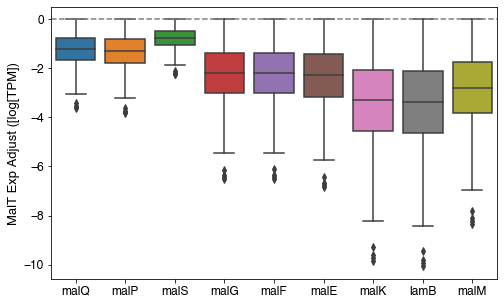

In [46]:
iM_expression_adjustments_dir('MalT')

Also seems to follow the expected pattern; the genes' expressions are down-adjusted to account for MalT activation

### LsrR (Small iModulon/Regulon, Strictly Represses)

We expect this time to see positive adjustments

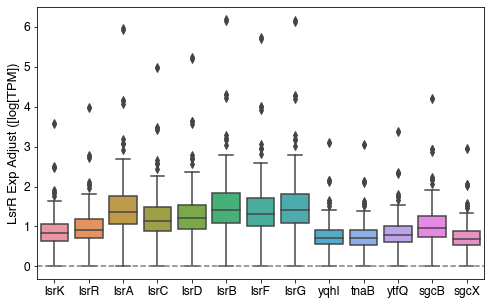

In [47]:
iM_expression_adjustments_dir('LsrR')

So this actually had negative adjustments, maybe the signs are wrong in the S vector here

### CysB (Medium iModulon/Regulon, Dual Activator)

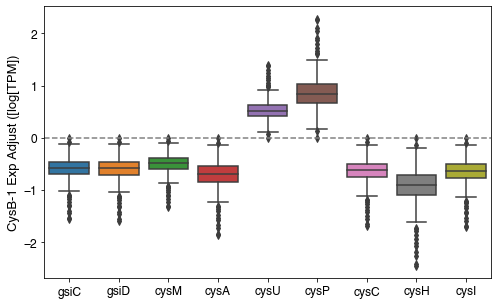

In [48]:
iM_expression_adjustments_dir('CysB-1')

## Save Basal Expressions

In [49]:
X_basal_reg.to_csv('data/X_basal_reg.csv')
X_basal_reg_dir.to_csv('data/X_basal_reg_dir.csv')